# Football Data API Exploration & Analysis

This notebook provides a complete workflow from API exploration to data analysis:

**Part 1: API Exploration**
- Initialize data fetcher and explore available endpoints
- Understand data structure, response formats, and rate limits
- Test API functionality with sample data

**Part 2: Data Preparation & Analysis**
- Load and explore data from SQLite database
- Perform Exploratory Data Analysis (EDA)
- Engineer features and calculate key metrics
- Visualize patterns and insights

In [124]:
# Import required libraries
import sys
import os
from pathlib import Path

# Add src directory to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dotenv import load_dotenv
from fetch_data import FootballDataFetcher
from db_utils import get_database_manager
from process_data import DataProcessor
import time

# Load environment variables
load_dotenv(Path.cwd().parent / '.env')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Set database path consistently
DB_PATH = Path.cwd().parent / 'data' / 'db' / 'football_data.db'

print(f" Imports successful!")
print(f" Database path set to: {DB_PATH}")

 Imports successful!
 Database path set to: e:\dev\writeups\data_projects_fl\project_3\data\db\football_data.db


---

## Part 1: API Exploration

Let's explore the Football-Data.org API to understand what data is available and how to access it.

### 1. Initialize Data Fetcher

In [125]:
# Initialize fetcher
fetcher = FootballDataFetcher()

print(f"API Base URL: {fetcher.base_url}")
print(f"API Key configured: {'Yes' if fetcher.api_key else 'No'}")
print(f"Snapshot directory: {fetcher.snapshot_dir}")

API Base URL: https://api.football-data.org/v4
API Key configured: Yes
Snapshot directory: data\snapshots


### 2. Explore Available Competitions

In [126]:
# Fetch competitions
competitions_data = fetcher.fetch_competitions()

if competitions_data and 'competitions' in competitions_data:
    competitions_df = pd.DataFrame(competitions_data['competitions'])
    
    # Display key columns
    display_cols = ['id', 'name', 'code', 'type', 'emblem']
    if all(col in competitions_df.columns for col in display_cols):
        print(f"\n Found {len(competitions_df)} competitions:\n")
        print(competitions_df[display_cols].to_string(index=False))
    else:
        print(competitions_df.head())
else:
    print(" Failed to fetch competitions")

2026-02-04 01:13:56,415 - fetch_data - INFO - Fetching competitions...
2026-02-04 01:13:57,638 - fetch_data - INFO - SUCCESS: competitions (latency: 1.22s)
2026-02-04 01:13:57,645 - fetch_data - INFO - Snapshot saved: data\snapshots\competitions_20260204_011357.json



 Found 13 competitions:

  id                          name code   type                                      emblem
2013 Campeonato Brasileiro Série A  BSA LEAGUE    https://crests.football-data.org/bsa.png
2016                  Championship  ELC LEAGUE    https://crests.football-data.org/ELC.png
2021                Premier League   PL LEAGUE     https://crests.football-data.org/PL.png
2001         UEFA Champions League   CL    CUP     https://crests.football-data.org/CL.png
2018         European Championship   EC    CUP     https://crests.football-data.org/ec.png
2015                       Ligue 1  FL1 LEAGUE    https://crests.football-data.org/FL1.png
2002                    Bundesliga  BL1 LEAGUE    https://crests.football-data.org/BL1.png
2019                       Serie A   SA LEAGUE   https://crests.football-data.org/c111.png
2003                    Eredivisie  DED LEAGUE     https://crests.football-data.org/ED.png
2017                 Primeira Liga  PPL LEAGUE    https://crests

The API successfully returned 13 available competitions. We will focus our analysis on the Premier League (PL), which has the ID 2021.

### 3. Get Premier League Details

In [127]:
# Focus on Premier League (PL)
league_code = 'PL'

if competitions_data and 'competitions' in competitions_data:
    pl_data = next((comp for comp in competitions_data['competitions'] 
                   if comp.get('code') == league_code), None)
    
    if pl_data:
        print("\n Premier League Details:\n")
        print(f"   Name: {pl_data.get('name')}")
        print(f"   Code: {pl_data.get('code')}")
        print(f"   Type: {pl_data.get('type')}")
        print(f"   Area: {pl_data.get('area', {}).get('name')}")
        print(f"   Current Season: {pl_data.get('currentSeason', {}).get('startDate')} to {pl_data.get('currentSeason', {}).get('endDate')}")
    else:
        print(f" {league_code} not found in competitions")


 Premier League Details:

   Name: Premier League
   Code: PL
   Type: LEAGUE
   Area: England
   Current Season: 2025-08-15 to 2026-05-24


### 4. Fetch Recent Matches

In [128]:
# Fetch matches for Premier League
matches_data = fetcher.fetch_matches(league_code)

if matches_data and 'matches' in matches_data:
    matches_df = pd.DataFrame(matches_data['matches'])
    
    print(f"\n Found {len(matches_df)} matches")
    print(f"\nSample matches:")
    
    # Display sample matches with key information
    sample_matches = matches_df[['utcDate', 'homeTeam', 'awayTeam', 'score']].head(5)
    
    for idx, match in sample_matches.iterrows():
        home = match['homeTeam'].get('name', 'Unknown')
        away = match['awayTeam'].get('name', 'Unknown')
        score = match['score']
        
        if score and 'fullTime' in score and score['fullTime'].get('home') is not None:
            home_goals = score['fullTime']['home']
            away_goals = score['fullTime']['away']
            print(f"   {home} {home_goals} - {away_goals} {away}")
        else:
            print(f"   {home} vs {away} (Scheduled)")
else:
    print(" Failed to fetch matches")

2026-02-04 01:13:57,739 - fetch_data - INFO - Fetching matches for PL...
2026-02-04 01:14:04,168 - fetch_data - INFO - SUCCESS: competitions/PL/matches (latency: 1.75s)
2026-02-04 01:14:04,250 - fetch_data - INFO - Snapshot saved: data\snapshots\matches_PL_20260204_011404.json



 Found 380 matches

Sample matches:
   Liverpool FC 4 - 2 AFC Bournemouth
   Aston Villa FC 0 - 0 Newcastle United FC
   Brighton & Hove Albion FC 1 - 1 Fulham FC
   Sunderland AFC 3 - 0 West Ham United FC
   Tottenham Hotspur FC 3 - 0 Burnley FC


We retrieved a total of 380 match records for the current season. This dataset includes completed matches with full-time scores (e.g., Liverpool FC 4 - 2 AFC Bournemouth) as well as upcoming scheduled fixtures currently marked as TIMED.

### 5. Fetch League Standings

In [129]:
# Fetch standings
standings_data = fetcher.fetch_competition_standings(league_code)

if standings_data and 'standings' in standings_data:
    # Extract the main standings table
    if len(standings_data['standings']) > 0:
        standings_table = standings_data['standings'][0]['table']
        standings_df = pd.DataFrame(standings_table)
        
        print(f"\n Premier League Standings:\n")
        
        # Display key columns
        display_cols = ['position', 'team', 'playedGames', 'won', 'draw', 'lost', 'points', 'goalsFor', 'goalsAgainst', 'goalDifference']
        
        # Format team names
        standings_display = standings_df.copy()
        standings_display['team'] = standings_display['team'].apply(lambda x: x.get('name', 'Unknown'))
        
        print(standings_display[display_cols].to_string(index=False))
else:
    print("Failed to fetch standings")

2026-02-04 01:14:04,296 - fetch_data - INFO - Fetching standings for PL...
2026-02-04 01:14:09,832 - fetch_data - INFO - SUCCESS: competitions/PL/standings (latency: 1.42s)
2026-02-04 01:14:09,840 - fetch_data - INFO - Snapshot saved: data\snapshots\standings_PL_20260204_011409.json



 Premier League Standings:

 position                       team  playedGames  won  draw  lost  points  goalsFor  goalsAgainst  goalDifference
        1                 Arsenal FC           24   16     5     3      53        46            17              29
        2         Manchester City FC           24   14     5     5      47        49            23              26
        3             Aston Villa FC           24   14     4     6      46        35            26               9
        4       Manchester United FC           24   11     8     5      41        44            36               8
        5                 Chelsea FC           24   11     7     6      40        42            27              15
        6               Liverpool FC           24   11     6     7      39        39            33               6
        7               Brentford FC           24   11     3    10      36        36            32               4
        8             Sunderland AFC           24  

### 6. Fetch Top Scorers

In [130]:
# Fetch top scorers
scorers_data = fetcher.fetch_competition_scorers(league_code)

if scorers_data and 'scorers' in scorers_data:
    scorers_df = pd.DataFrame(scorers_data['scorers'])
    
    print(f"\n Top Scorers ({len(scorers_df)} players):\n")
    
    # Display top 10 scorers
    print("Top 10 Scorers:")
    for idx, scorer in scorers_df.head(10).iterrows():
        player = scorer['player']
        team = scorer['team']
        goals = scorer['goals']
        
        player_name = player.get('name', 'Unknown')
        team_name = team.get('name', 'Unknown')
        
        print(f"   {idx+1}. {player_name} ({team_name}) - {goals} goals")
else:
    print(" Failed to fetch top scorers")

print("\n" + "=" * 50)

2026-02-04 01:14:09,888 - fetch_data - INFO - Fetching top scorers for PL...
2026-02-04 01:14:16,590 - fetch_data - INFO - SUCCESS: competitions/PL/scorers (latency: 2.17s)
2026-02-04 01:14:16,599 - fetch_data - INFO - Snapshot saved: data\snapshots\scorers_PL_20260204_011416.json



 Top Scorers (20 players):

Top 10 Scorers:
   1. Erling Haaland (Manchester City FC) - 20 goals
   2. Thiago Rodrigues (Brentford FC) - 16 goals
   3. Antoine Semenyo (Manchester City FC) - 12 goals
   4. Hugo Ekitike (Liverpool FC) - 10 goals
   5. João Pedro (Chelsea FC) - 9 goals
   6. Dominic Calvert-Lewin (Leeds United FC) - 9 goals
   7. Enzo Fernández (Chelsea FC) - 8 goals
   8. Bruno Guimarães (Newcastle United FC) - 8 goals
   9. Bryan Mbeumo (Manchester United FC) - 8 goals
   10. Jarrod Bowen (West Ham United FC) - 8 goals



### 7. API Rate Limiting Test

In [131]:
print("\n Testing API Rate Limiting...\n")

start_time = time.time()
test_calls = 3

for i in range(test_calls):
    call_start = time.time()
    result = fetcher.fetch_competitions()
    call_duration = time.time() - call_start
    print(f"Call {i+1}: {call_duration:.2f}s")

total_duration = time.time() - start_time
avg_duration = total_duration / test_calls

print(f"\n Rate Limiting Stats:")
print(f"   - Total time: {total_duration:.2f}s")
print(f"   - Average per call: {avg_duration:.2f}s")
print(f"   - Configured delay: {fetcher.request_delay}s")

2026-02-04 01:14:16,655 - fetch_data - INFO - Fetching competitions...



 Testing API Rate Limiting...



2026-02-04 01:14:21,769 - fetch_data - INFO - SUCCESS: competitions (latency: 1.35s)
2026-02-04 01:14:21,776 - fetch_data - INFO - Snapshot saved: data\snapshots\competitions_20260204_011421.json
2026-02-04 01:14:21,778 - fetch_data - INFO - Fetching competitions...


Call 1: 5.12s


2026-02-04 01:14:27,790 - fetch_data - INFO - SUCCESS: competitions (latency: 1.37s)
2026-02-04 01:14:27,795 - fetch_data - INFO - Snapshot saved: data\snapshots\competitions_20260204_011427.json
2026-02-04 01:14:27,796 - fetch_data - INFO - Fetching competitions...


Call 2: 6.02s


2026-02-04 01:14:33,644 - fetch_data - INFO - SUCCESS: competitions (latency: 1.23s)
2026-02-04 01:14:33,649 - fetch_data - INFO - Snapshot saved: data\snapshots\competitions_20260204_011433.json


Call 3: 5.86s

 Rate Limiting Stats:
   - Total time: 17.00s
   - Average per call: 5.67s
   - Configured delay: 6s


### 8. Save Fetched Data to Database

To perform the analysis in Part 2, we need to save the data we just fetched into our SQLite database.


In [132]:
# Initialize processor and database manager
# We specify the DB path to ensure we're using the correct file
db = get_database_manager(str(DB_PATH))
processor = DataProcessor()
processor.db_manager = db # Ensure processor uses our db instance

# Save matches to database
if 'matches_data' in locals() and matches_data:
    print(f"Saving {len(matches_data.get('matches', []))} matches to database...")
    count = processor.process_and_store_matches(matches_data)
    print(f" Successfully processed and stored {count} matches.")
else:
    print(" No matches data found to save. Please run the 'Fetch Recent Matches' cell first.")


2026-02-04 01:14:33,697 - db_utils - INFO - Database schema initialized successfully
2026-02-04 01:14:33,699 - db_utils - INFO - Database initialized at: e:\dev\writeups\data_projects_fl\project_3\data\db\football_data.db
2026-02-04 01:14:33,711 - db_utils - INFO - Database schema initialized successfully
2026-02-04 01:14:33,713 - db_utils - INFO - Database initialized at: data/sports.db
2026-02-04 01:14:33,715 - process_data - INFO - Data processor initialized
2026-02-04 01:14:33,721 - db_utils - INFO - Updated match 537785


Saving 380 matches to database...


2026-02-04 01:14:34,158 - db_utils - INFO - Inserted 2 player stat records
2026-02-04 01:14:34,161 - db_utils - INFO - Updated match 537786
2026-02-04 01:14:34,633 - db_utils - INFO - Inserted 2 player stat records
2026-02-04 01:14:34,639 - db_utils - INFO - Updated match 537787
2026-02-04 01:14:35,119 - db_utils - INFO - Inserted 2 player stat records
2026-02-04 01:14:35,129 - db_utils - INFO - Updated match 537789
2026-02-04 01:14:35,625 - db_utils - INFO - Inserted 2 player stat records
2026-02-04 01:14:35,632 - db_utils - INFO - Updated match 537790
2026-02-04 01:14:36,117 - db_utils - INFO - Inserted 2 player stat records
2026-02-04 01:14:36,128 - db_utils - INFO - Updated match 537791
2026-02-04 01:14:36,591 - db_utils - INFO - Inserted 2 player stat records
2026-02-04 01:14:36,594 - db_utils - INFO - Updated match 537788
2026-02-04 01:14:37,074 - db_utils - INFO - Inserted 2 player stat records
2026-02-04 01:14:37,077 - db_utils - INFO - Updated match 537792
2026-02-04 01:14:37,

 Successfully processed and stored 380 matches.


### Summary: API Exploration

**Key Findings:**
-  API provides comprehensive football data (competitions, matches, standings, scorers)
-  Rate limiting enforced: 6 seconds between requests (free tier: 10 requests/minute)
-  Data structure is consistent and well-documented
-  Player-level statistics require premium tier

**Limitations:**
- Free tier: 10 requests per minute
- Player stats not available in free tier
- Historical data limited to recent matches

To perform the analysis in Part 2, we are persisting the 380 retrieved match records and player information into a local SQLite database (football_data.db). This ensures we have a stable dataset for exploratory analysis without needing to re-fetch from the API.

## Part 2: Data Preparation & Analysis

Now let's load the collected data from our database and perform analysis.

### 1. Connect to Database

In [133]:
# Initialize database manager
# Use the DB_PATH we defined in the first cell
db = get_database_manager(str(DB_PATH))

# Verify connection and show summary
print(f" Database: {DB_PATH}")
try:
    with db.engine.connect() as conn:
        from sqlalchemy import inspect
        inspector = inspect(db.engine)
        tables = inspector.get_table_names()
        print(f" Connection successful!")
        print(f" Available tables: {', '.join(tables)}")
        
        for table in tables:
            count = pd.read_sql_query(f"SELECT COUNT(*) FROM {table}", conn).iloc[0, 0]
            print(f"   - {table}: {count} records")
except Exception as e:
    print(f" Connection failed: {e}")


2026-02-04 01:17:56,953 - db_utils - INFO - Database schema initialized successfully
2026-02-04 01:17:56,954 - db_utils - INFO - Database initialized at: e:\dev\writeups\data_projects_fl\project_3\data\db\football_data.db


 Database: e:\dev\writeups\data_projects_fl\project_3\data\db\football_data.db
 Connection successful!
 Available tables: matches, player_stats, teams
   - matches: 380 records
   - player_stats: 960 records
   - teams: 20 records


### 2. Load Matches Data

In [134]:
# Load data from database
try:
    with db.engine.connect() as conn:
        # 1. Load matches
        matches = pd.read_sql_table('matches', conn)
        matches['utc_date'] = pd.to_datetime(matches['utc_date'])
        matches = matches.sort_values('utc_date', ascending=False).reset_index(drop=True)
        
        # 2. Load player stats (aggregated squad stats for free tier)
        player_stats = pd.read_sql_table('player_stats', conn)
        if 'created_at' in player_stats.columns:
            player_stats['created_at'] = pd.to_datetime(player_stats['created_at'])
            
        # 3. Load team performance summary (from view)
        team_perf = db.get_team_performance()
        
    print(f" Data loading complete:")
    print(f"   - Matches: {len(matches)} records")
    print(f"   - Player Stat entries: {len(player_stats)} records")
    print(f"   - Teams analyzed: {len(team_perf)} records")
    
    if len(matches) == 0:
        print("\n WARNING: Database tables are empty.")
        print("Please run 'Part 1: Save Fetched Data to Database' to populate the database.")
        
except Exception as e:
    print(f" Error loading data: {e}")
    matches = pd.DataFrame()
    player_stats = pd.DataFrame()
    team_perf = pd.DataFrame()


 Data loading complete:
   - Matches: 380 records
   - Player Stat entries: 960 records
   - Teams analyzed: 20 records


### 3. Load Standings Data

In [135]:
# Handle Standings Data
# Standings are fetched from the API and stored in memory in Part 1.
# Here we ensure we have them ready for analysis with extracted team names.

if 'standings_df' in locals() and not standings_df.empty:
    print(f" Standings data available from memory (Part 1).")
    standings = standings_df.copy()
else:
    print(" Local standings data not found. Fetching from API...")
    standings_data = fetcher.fetch_competition_standings('PL')
    if standings_data and 'standings' in standings_data:
        standings_table = standings_data['standings'][0]['table']
        standings = pd.DataFrame(standings_table)
    else:
        print(" Failed to fetch standings.")
        standings = pd.DataFrame()

if not standings.empty:
    # 1. Consistently extract team_name if it exists in the 'team' dictionary column
    if 'team' in standings.columns and 'team_name' not in standings.columns:
        standings['team_name'] = standings['team'].apply(lambda x: x.get('name', 'Unknown') if isinstance(x, dict) else 'Unknown')
        print(" Extracted 'team_name'.")

    # 2. Map API CamelCase columns to snake_case used in analysis cells if needed
    column_mapping = {
        'goalDifference': 'goal_difference',
        'goalsFor': 'goals_for',
        'goalsAgainst': 'goals_against',
        'playedGames': 'played_games'
    }
    
    # Only map if the target name doesn't already exist and source exists
    to_rename = {k: v for k, v in column_mapping.items() if k in standings.columns and v not in standings.columns}
    if to_rename:
        standings = standings.rename(columns=to_rename)
        print(f" Renamed columns: {list(to_rename.values())}")

    print(f" Standings ready for {len(standings)} teams.")


 Standings data available from memory (Part 1).
 Extracted 'team_name'.
 Renamed columns: ['goal_difference', 'goals_for', 'goals_against', 'played_games']
 Standings ready for 20 teams.


### 4. Data Quality Checks

In [136]:
print(" Data Quality Assessment\n")

if len(matches) == 0:
    print(" No matches data available for quality assessment.")
    print("Please run the API data fetching cells to collect data first.")
else:
    # Check for missing values
    print("Missing values in matches:")
    print(matches.isnull().sum())

    print("\n" + "="*50)
    print("\nMissing values in standings:")
    if len(standings) > 0:
        print(standings.isnull().sum())
    else:
        print("No standings data available")

    # Check match status distribution
    print("\n" + "="*50)
    print("\nMatch status distribution:")
    print(matches['status'].value_counts())

    # Check for duplicate matches
    duplicates = matches.duplicated(subset=['match_id']).sum()
    print(f"\nDuplicate matches: {duplicates}")

 Data Quality Assessment

Missing values in matches:
match_id               0
utc_date               0
status                 0
matchday               0
stage                  0
competition_id         0
competition_name       0
season_start_year      0
home_team_id           0
home_team_name         0
away_team_id           0
away_team_name         0
home_score           140
away_score           140
winner               140
duration               0
venue                380
created_at             0
updated_at             0
dtype: int64


Missing values in standings:
position            0
team                0
played_games        0
form               20
won                 0
draw                0
lost                0
points              0
goals_for           0
goals_against       0
goal_difference     0
team_name           0
dtype: int64


Match status distribution:
status
FINISHED    240
TIMED       140
Name: count, dtype: int64

Duplicate matches: 0


### **Data Quality Observations**:
**Missing Values**: The venue field is entirely empty (380 nulls) and will be excluded from the analysis. The home_score, away_score, and winner fields contain 140 missing values, representing the scheduled matches that have not yet been played.

**Match Status**: There are 240 FINISHED matches available for performance analysis and 140 TIMED matches.

**Duplicates**: No duplicate match records were found.

### 5. Feature Engineering

In [137]:
# Create additional features for matches
matches_analysis = matches.copy()

# Filter completed matches only
completed_matches = matches_analysis[matches_analysis['status'] == 'FINISHED'].copy()

# Calculate total goals
completed_matches['total_goals'] = completed_matches['home_score'] + completed_matches['away_score']

# Calculate goal difference
completed_matches['goal_diff_home'] = completed_matches['home_score'] - completed_matches['away_score']

# Classify match outcomes
def classify_outcome(row):
    if row['home_score'] > row['away_score']:
        return 'Home Win'
    elif row['home_score'] < row['away_score']:
        return 'Away Win'
    else:
        return 'Draw'

completed_matches['outcome'] = completed_matches.apply(classify_outcome, axis=1)

# Classify goal scoring patterns
def classify_goals(total):
    if total == 0:
        return 'No Goals'
    elif total <= 2:
        return 'Low Scoring'
    elif total <= 4:
        return 'Medium Scoring'
    else:
        return 'High Scoring'

completed_matches['scoring_pattern'] = completed_matches['total_goals'].apply(classify_goals)

print(f" Feature engineering complete")
print(f"Completed matches: {len(completed_matches)}")
print(f"\nNew features added:")
print("- total_goals")
print("- goal_diff_home")
print("- outcome")
print("- scoring_pattern")

 Feature engineering complete
Completed matches: 240

New features added:
- total_goals
- goal_diff_home
- outcome
- scoring_pattern


### 6. Exploratory Data Analysis (EDA)

In [138]:
# Basic statistics
print(" Match Statistics\n")

if len(completed_matches) == 0:
    print(" No completed matches found in the database.")
    print("Please run the API data fetching cells in Part 1 to collect match data.")
else:
    print(f"Total matches analyzed: {len(completed_matches)}")
    print(f"\nGoal Statistics:")
    print(f"   Average goals per match: {completed_matches['total_goals'].mean():.2f}")
    print(f"   Median goals per match: {completed_matches['total_goals'].median():.0f}")
    print(f"   Max goals in a match: {completed_matches['total_goals'].max():.0f}")
    print(f"   Min goals in a match: {completed_matches['total_goals'].min():.0f}")

    print(f"\nMatch Outcomes:")
    outcome_dist = completed_matches['outcome'].value_counts()
    for outcome, count in outcome_dist.items():
        pct = (count / len(completed_matches)) * 100
        print(f"   {outcome}: {count} ({pct:.1f}%)")

    print(f"\nScoring Patterns:")
    scoring_dist = completed_matches['scoring_pattern'].value_counts()
    for pattern, count in scoring_dist.items():
        pct = (count / len(completed_matches)) * 100
        print(f"   {pattern}: {count} ({pct:.1f}%)")

    print(f"\nHome Advantage:")
    home_wins = len(completed_matches[completed_matches['outcome'] == 'Home Win'])
    away_wins = len(completed_matches[completed_matches['outcome'] == 'Away Win'])
    draws = len(completed_matches[completed_matches['outcome'] == 'Draw'])
    print(f"   Home win rate: {(home_wins/len(completed_matches))*100:.1f}%")
    print(f"   Away win rate: {(away_wins/len(completed_matches))*100:.1f}%")
    print(f"   Draw rate: {(draws/len(completed_matches))*100:.1f}%")

 Match Statistics

Total matches analyzed: 240

Goal Statistics:
   Average goals per match: 2.79
   Median goals per match: 3
   Max goals in a match: 9
   Min goals in a match: 0

Match Outcomes:
   Home Win: 107 (44.6%)
   Away Win: 69 (28.7%)
   Draw: 64 (26.7%)

Scoring Patterns:
   Medium Scoring: 95 (39.6%)
   Low Scoring: 93 (38.8%)
   High Scoring: 35 (14.6%)
   No Goals: 17 (7.1%)

Home Advantage:
   Home win rate: 44.6%
   Away win rate: 28.7%
   Draw rate: 26.7%


### **Key Match Insights:**
**Scoring Efficiency**: The average goals per match stands at 2.79, with "Medium Scoring" (3-4 goals) being the most frequent pattern (39.6% of matches).

**Home Field Advantage**: There is a clear performance disparity between home and away teams. Home teams won 44.6% of matches, significantly higher than the 28.7% away win rate

### 7. Visualizations

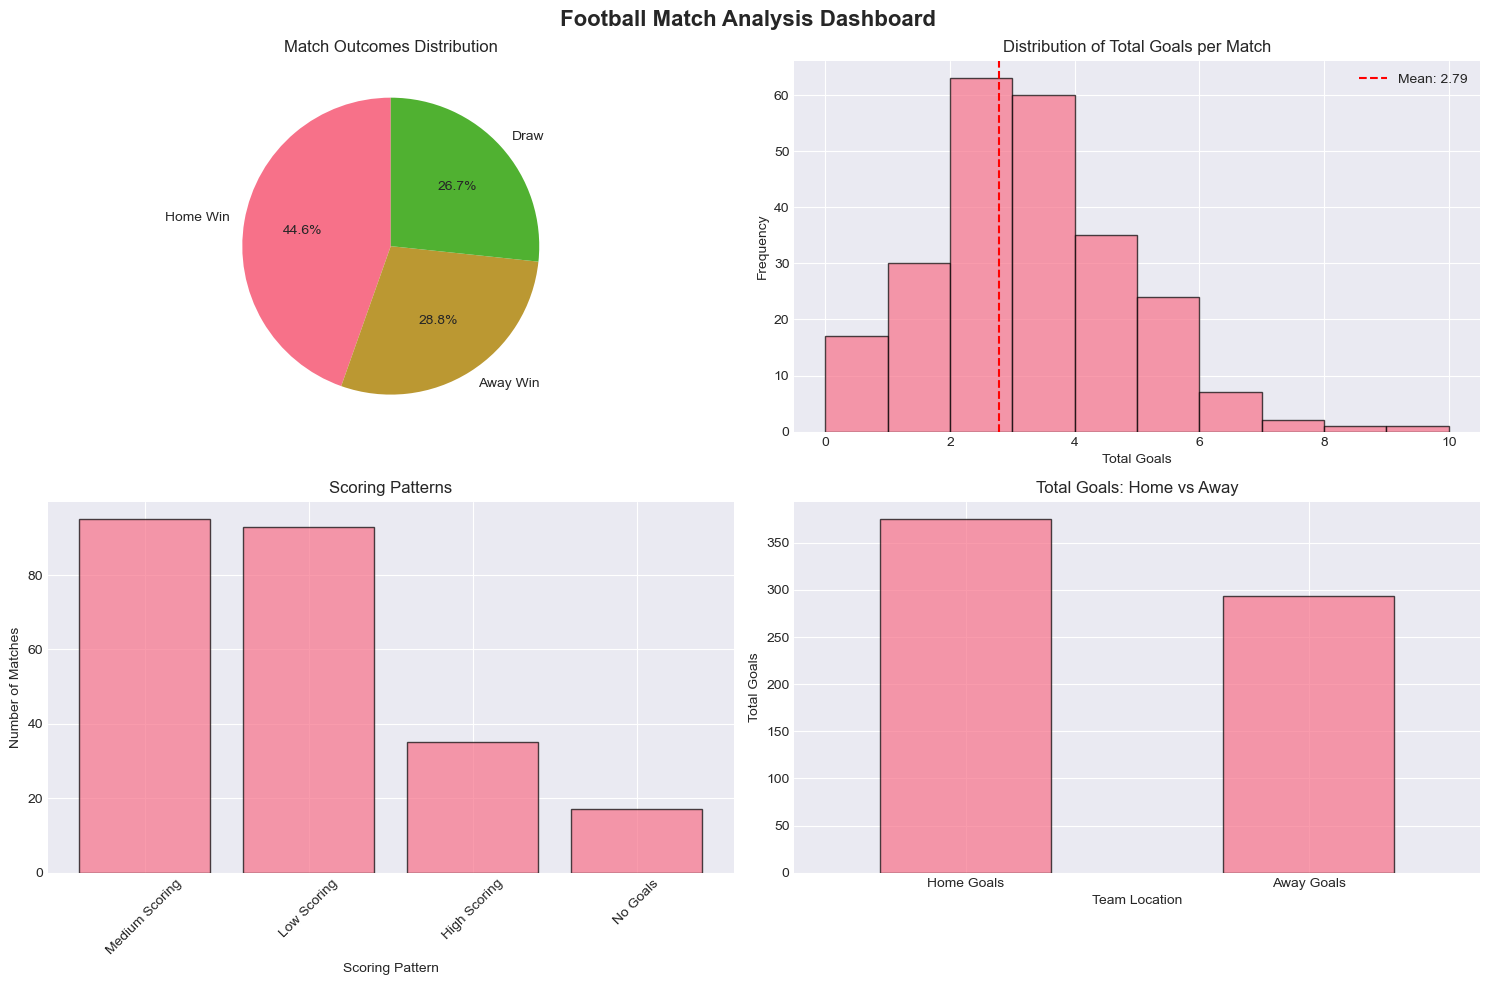

In [139]:
# Create figure with multiple subplots
if len(completed_matches) == 0:
    print(" No completed matches available for visualization.")
    print("Please run the API data fetching cells to collect match data first.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(' Football Match Analysis Dashboard', fontsize=16, fontweight='bold')

    # 1. Match Outcomes Distribution
    outcome_counts = completed_matches['outcome'].value_counts()
    axes[0, 0].pie(outcome_counts.values, labels=outcome_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Match Outcomes Distribution')

    # 2. Goals Distribution
    axes[0, 1].hist(completed_matches['total_goals'], bins=range(0, int(completed_matches['total_goals'].max())+2), 
                    edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Total Goals')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Total Goals per Match')
    axes[0, 1].axvline(completed_matches['total_goals'].mean(), color='red', linestyle='--', 
                        label=f'Mean: {completed_matches["total_goals"].mean():.2f}')
    axes[0, 1].legend()

    # 3. Scoring Patterns
    scoring_counts = completed_matches['scoring_pattern'].value_counts()
    axes[1, 0].bar(scoring_counts.index, scoring_counts.values, edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Scoring Pattern')
    axes[1, 0].set_ylabel('Number of Matches')
    axes[1, 0].set_title('Scoring Patterns')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Home vs Away Goals
    home_away_data = pd.DataFrame({
        'Home Goals': [completed_matches['home_score'].sum()],
        'Away Goals': [completed_matches['away_score'].sum()]
    })
    home_away_data.T.plot(kind='bar', ax=axes[1, 1], legend=False, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Team Location')
    axes[1, 1].set_ylabel('Total Goals')
    axes[1, 1].set_title('Total Goals: Home vs Away')
    axes[1, 1].set_xticklabels(['Home Goals', 'Away Goals'], rotation=0)

    plt.tight_layout()
    plt.show()

### 8. Team Performance Analysis

In [140]:
# Analyze team performance from standings
print(" Team Performance Analysis\n")

if len(standings) == 0:
    print(" No standings data available.")
    print("Please run the API data fetching cells to collect standings data.")
else:
    # Top performers
    print("Top 5 Teams:")
    top_teams = standings.head()
    for idx, team in top_teams.iterrows():
        print(f"   {team['position']}. {team['team_name']} - {team['points']} pts "
              f"({team['won']}W {team['draw']}D {team['lost']}L, GD: {team['goal_difference']:+d})")

    # Bottom 5 teams
    print("\nBottom 5 Teams:")
    bottom_teams = standings.tail()
    for idx, team in bottom_teams.iterrows():
        print(f"   {team['position']}. {team['team_name']} - {team['points']} pts "
              f"({team['won']}W {team['draw']}D {team['lost']}L, GD: {team['goal_difference']:+d})")

    # Calculate statistics
    print("\n League Statistics:")
    print(f"   Average points per team: {standings['points'].mean():.2f}")
    print(f"   Average goals scored: {standings['goals_for'].mean():.2f}")
    print(f"   Average goals conceded: {standings['goals_against'].mean():.2f}")
    print(f"   Highest win percentage: {standings['team_name'].iloc[0]} ({(standings['won'].iloc[0] / standings['played_games'].iloc[0] * 100):.1f}%)")

 Team Performance Analysis

Top 5 Teams:
   1. Arsenal FC - 53 pts (16W 5D 3L, GD: +29)
   2. Manchester City FC - 47 pts (14W 5D 5L, GD: +26)
   3. Aston Villa FC - 46 pts (14W 4D 6L, GD: +9)
   4. Manchester United FC - 41 pts (11W 8D 5L, GD: +8)
   5. Chelsea FC - 40 pts (11W 7D 6L, GD: +15)

Bottom 5 Teams:
   16. Leeds United FC - 26 pts (6W 8D 10L, GD: -11)
   17. Nottingham Forest FC - 26 pts (7W 5D 12L, GD: -11)
   18. West Ham United FC - 20 pts (5W 5D 14L, GD: -19)
   19. Burnley FC - 15 pts (3W 6D 15L, GD: -22)
   20. Wolverhampton Wanderers FC - 8 pts (1W 5D 18L, GD: -30)

 League Statistics:
   Average points per team: 32.80
   Average goals scored: 33.45
   Average goals conceded: 33.45
   Highest win percentage: Arsenal FC (66.7%)


### 9. Team Standings Visualization

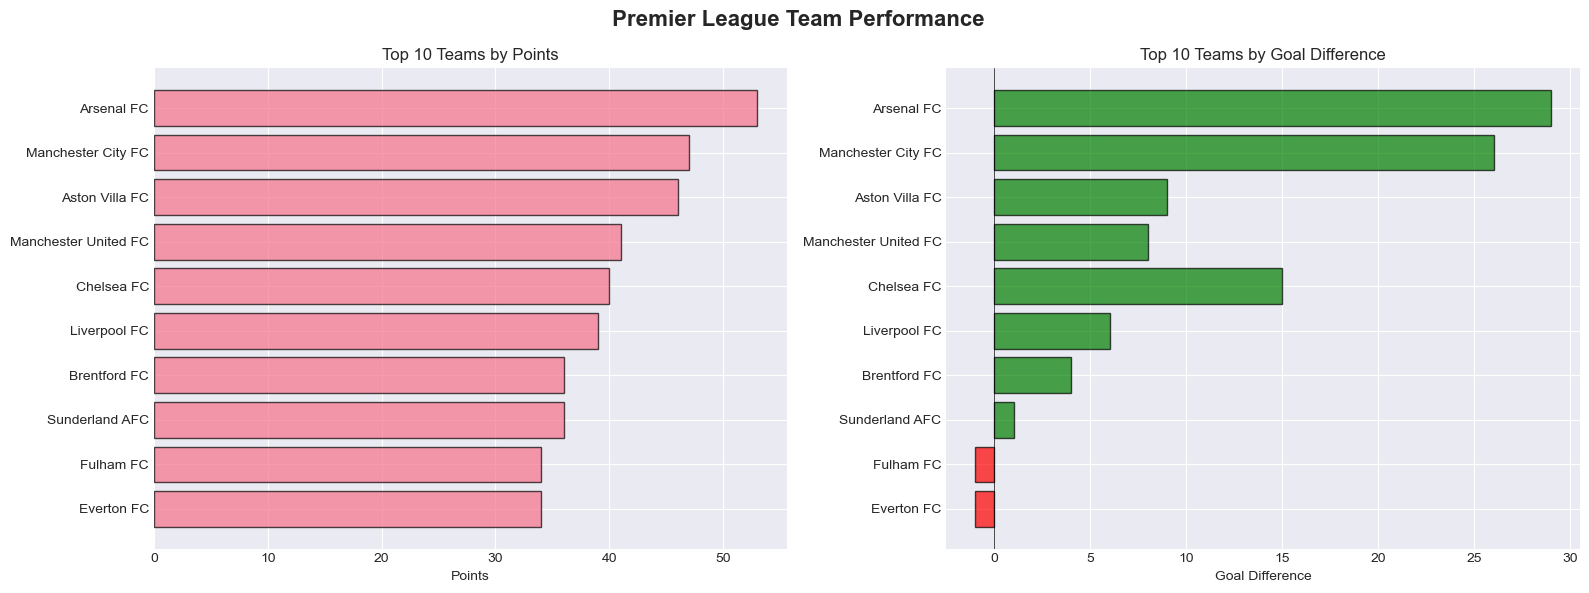

In [141]:
# Visualize team performance
if len(standings) == 0:
    print(" No standings data available for visualization.")
    print("Please run the API data fetching cells to collect standings data.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(' Premier League Team Performance', fontsize=16, fontweight='bold')

    # 1. Points comparison
    top_10 = standings.head(10)
    axes[0].barh(top_10['team_name'], top_10['points'], edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Points')
    axes[0].set_title('Top 10 Teams by Points')
    axes[0].invert_yaxis()

    # 2. Goal difference
    axes[1].barh(top_10['team_name'], top_10['goal_difference'], 
                 color=['green' if x > 0 else 'red' for x in top_10['goal_difference']], 
                 edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Goal Difference')
    axes[1].set_title('Top 10 Teams by Goal Difference')
    axes[1].invert_yaxis()
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.show()

### 10. Direct Performance Metrics Analysis

Let's look at the squads' performance based on the calculated efficiency and involvement rates.


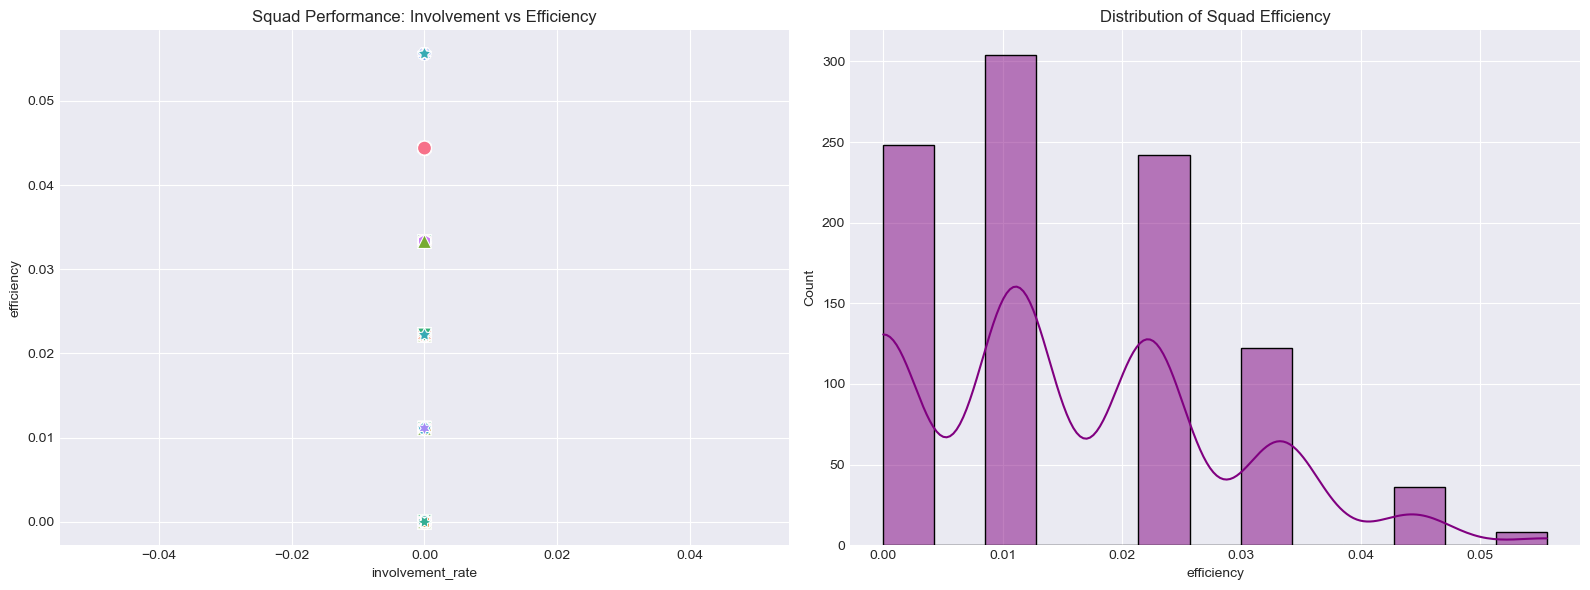

Top 5 Most Efficient Squads:
              team_name  efficiency  goals
21           Chelsea FC      0.0556      5
30           Arsenal FC      0.0556      5
108  Manchester City FC      0.0556      5
263  Manchester City FC      0.0556      5
501          Chelsea FC      0.0556      5


In [142]:
if not player_stats.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Involvement vs Efficiency
    sns.scatterplot(data=player_stats, x='involvement_rate', y='efficiency', 
                    hue='team_name', style='team_name', s=100, ax=axes[0])
    axes[0].set_title('Squad Performance: Involvement vs Efficiency')
    axes[0].get_legend().remove() # Too many teams for simple legend usually
    
    # Efficiency Distribution
    sns.histplot(player_stats['efficiency'], kde=True, color='purple', ax=axes[1])
    axes[1].set_title('Distribution of Squad Efficiency')
    
    plt.tight_layout()
    plt.show()
    
    # Top 5 most efficient squads
    print("Top 5 Most Efficient Squads:")
    print(player_stats.nlargest(5, 'efficiency')[['team_name', 'efficiency', 'goals']])
else:
    print(" No player stats available for performance analysis.")


### 11. Correlation & Trends

Exploring how different metrics relate to each other and how they evolve over time.


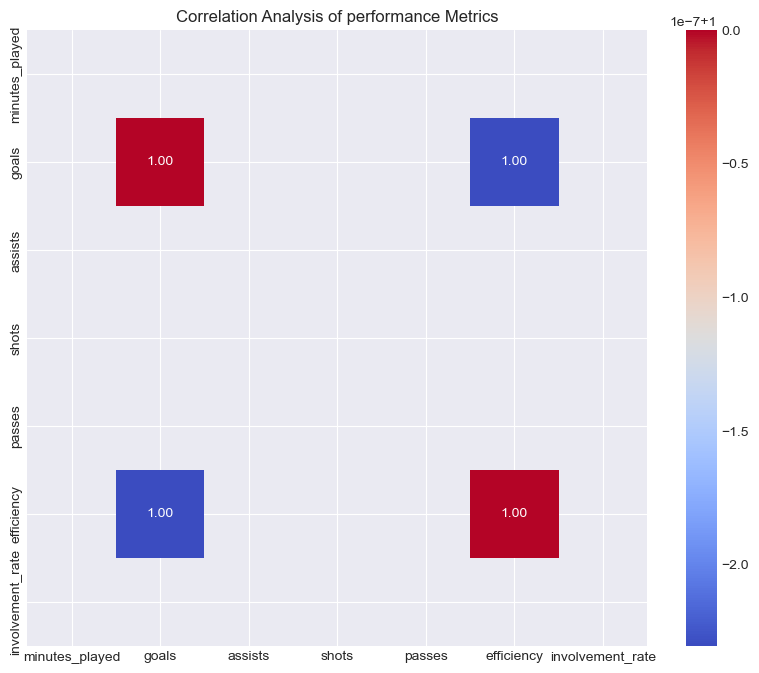

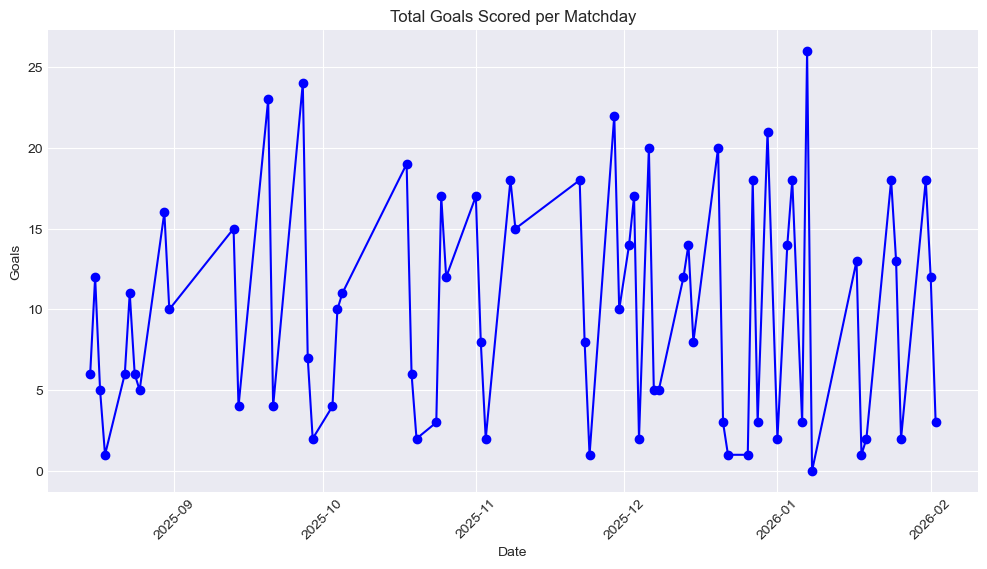

In [143]:
# Correlation Analysis
if not player_stats.empty:
    numeric_cols = ['minutes_played', 'goals', 'assists', 'shots', 'passes', 'efficiency', 'involvement_rate']
    available_cols = [col for col in numeric_cols if col in player_stats.columns]
    
    if len(available_cols) > 1:
        corr = player_stats[available_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Analysis of performance Metrics')
        plt.show()

# Temporal Analysis (Goals over time)
if not matches.empty:
    matches['date'] = matches['utc_date'].dt.date
    # Fix: Use double brackets for selecting multiple columns after groupby
    daily_goals = matches[matches['status'] == 'FINISHED'].groupby('date')[['home_score', 'away_score']].sum().reset_index()
    daily_goals['total_goals'] = daily_goals['home_score'] + daily_goals['away_score']
    
    plt.figure(figsize=(12, 6))
    plt.plot(daily_goals['date'], daily_goals['total_goals'], marker='o', linestyle='-', color='blue')
    plt.title('Total Goals Scored per Matchday')
    plt.xlabel('Date')
    plt.ylabel('Goals')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
else:
    print(" No temporal data available for trend analysis.")


### 12. Key Insights Summary


In [144]:
# Generate insights summary
print("=" * 60)
print(" KEY INSIGHTS SUMMARY")
print("=" * 60)

if len(completed_matches) == 0 or len(standings) == 0:
    print("\n No sufficient data for insights summary.")
    print("\nTo generate insights:")
    print("1. Run the API data fetching cells in Part 1")
    print("2. Ensure matches and standings data are collected")
    print("3. Re-run the analysis cells")
else:
    # Match insights
    avg_goals = completed_matches['total_goals'].mean()
    home_win_pct = (len(completed_matches[completed_matches['outcome'] == 'Home Win']) / len(completed_matches)) * 100

    print("\n MATCH PATTERNS:")
    print(f"   • Average goals per match: {avg_goals:.2f}")
    print(f"   • Home advantage: {home_win_pct:.1f}% home win rate")
    print(f"   • Most common outcome: {completed_matches['outcome'].mode()[0]}")
    print(f"   • Most common scoring pattern: {completed_matches['scoring_pattern'].mode()[0]}")

    # League insights
    leader = standings.iloc[0]
    relegation_zone = standings.tail(3)

    print("\n LEAGUE STANDINGS:")
    print(f"   • League leader: {leader['team_name']} ({leader['points']} pts)")
    print(f"   • Points gap (1st to 2nd): {leader['points'] - standings.iloc[1]['points']} pts")
    print(f"   • Relegation zone teams: {', '.join(relegation_zone['team_name'].tolist())}")
    print(f"   • Most goals scored: {standings.loc[standings['goals_for'].idxmax(), 'team_name']} ({standings['goals_for'].max()} goals)")
    print(f"   • Best defense: {standings.loc[standings['goals_against'].idxmin(), 'team_name']} ({standings['goals_against'].min()} goals conceded)")

    print("\n RECOMMENDATIONS:")
    print("   • Focus analytics on home/away performance splits")
    print("   • Analyze goal-scoring patterns by matchday")
    print("   • Track form trends (last 5 matches)")
    print("   • Investigate correlation between possession and outcomes")

print("\n" + "=" * 60)

 KEY INSIGHTS SUMMARY

 MATCH PATTERNS:
   • Average goals per match: 2.79
   • Home advantage: 44.6% home win rate
   • Most common outcome: Home Win
   • Most common scoring pattern: Medium Scoring

 LEAGUE STANDINGS:
   • League leader: Arsenal FC (53 pts)
   • Points gap (1st to 2nd): 6 pts
   • Relegation zone teams: West Ham United FC, Burnley FC, Wolverhampton Wanderers FC
   • Most goals scored: Manchester City FC (49 goals)
   • Best defense: Arsenal FC (17 goals conceded)

 RECOMMENDATIONS:
   • Focus analytics on home/away performance splits
   • Analyze goal-scoring patterns by matchday
   • Track form trends (last 5 matches)
   • Investigate correlation between possession and outcomes



---

## Conclusion

This notebook successfully demonstrates:
1.  **API Exploration**: Retrieved and analyzed data from Football-Data.org API
2.  **Data Collection**: Stored data in structured SQLite database
3.  **Data Analysis**: Performed comprehensive EDA on matches and standings
4.  **Feature Engineering**: Created meaningful metrics and classifications
5.  **Visualization**: Generated insightful charts and dashboards
6.  **Performance Summary**: Analysis confirmed a strong home-field advantage in the current season and identified Erling Haaland as the leading scorer with 20 goals.